In [71]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
tf.random.set_seed(5)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

### DATA EXPLORATION

In [114]:
image_directory = "C:/Users/laura/OneDrive/analysis_projects/PlantVillage"

In [115]:
batch_size = 32
img_size = 180

Import images in batches, split in train and validation sets and resize.

In [116]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  image_directory,
  validation_split=0.2, #80% training set
  subset="training",
  seed=5,
  image_size=(img_size, img_size), #resizing
  batch_size=batch_size)

Found 40000 files belonging to 33 classes.
Using 32000 files for training.


In [117]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_directory,
  validation_split=0.2, #20% validation and test sets
  subset="validation",
  seed=5,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 40000 files belonging to 33 classes.
Using 8000 files for validation.


In [118]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2) #10% test set
val_ds = val_ds.skip((val_batches) // 2) #10% validation set

In [119]:
type(train_ds) #tf.data.Dataset object

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [120]:
for image_batch, labels_batch in train_ds:
    print(f'X_train has a shape of: {image_batch.shape}')
    print(f'y_train has a shape of: {labels_batch.shape}')
    break

X_train has a shape of: (32, 180, 180, 3)
y_train has a shape of: (32,)


In [121]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [122]:
plants = []
ndiseases = 0

for plant in class_names:
    plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        ndiseases += 1

In [123]:
print(f"Unique Plants are: \n{np.unique(plants)}")

Unique Plants are: 
['Apple' 'Cherry_(including_sour)' 'Corn_(maize)' 'Grape' 'Peach'
 'Pepper,_bell' 'Potato' 'Strawberry' 'Tomato']


In [124]:
print("Number of plants: {}".format(len(np.unique(plants))))

Number of plants: 9


In [125]:
print("Number of diseases: {}".format(ndiseases))

Number of diseases: 24


In [126]:
# Number of images for each disease
nums = {}
for disease in class_names:
    nums[disease] = len(os.listdir(image_directory + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___Apple_scab,630
Apple___Black_rot,621
Apple___Cedar_apple_rust,275
Apple___healthy,1645
Cherry_(including_sour)___Powdery_mildew,1052
Cherry_(including_sour)___healthy,854
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,513
Corn_(maize)___Common_rust_,1192
Corn_(maize)___Northern_Leaf_Blight,985
Corn_(maize)___healthy,1162


Text(0.5, 1.0, 'Images per each class of plant disease')

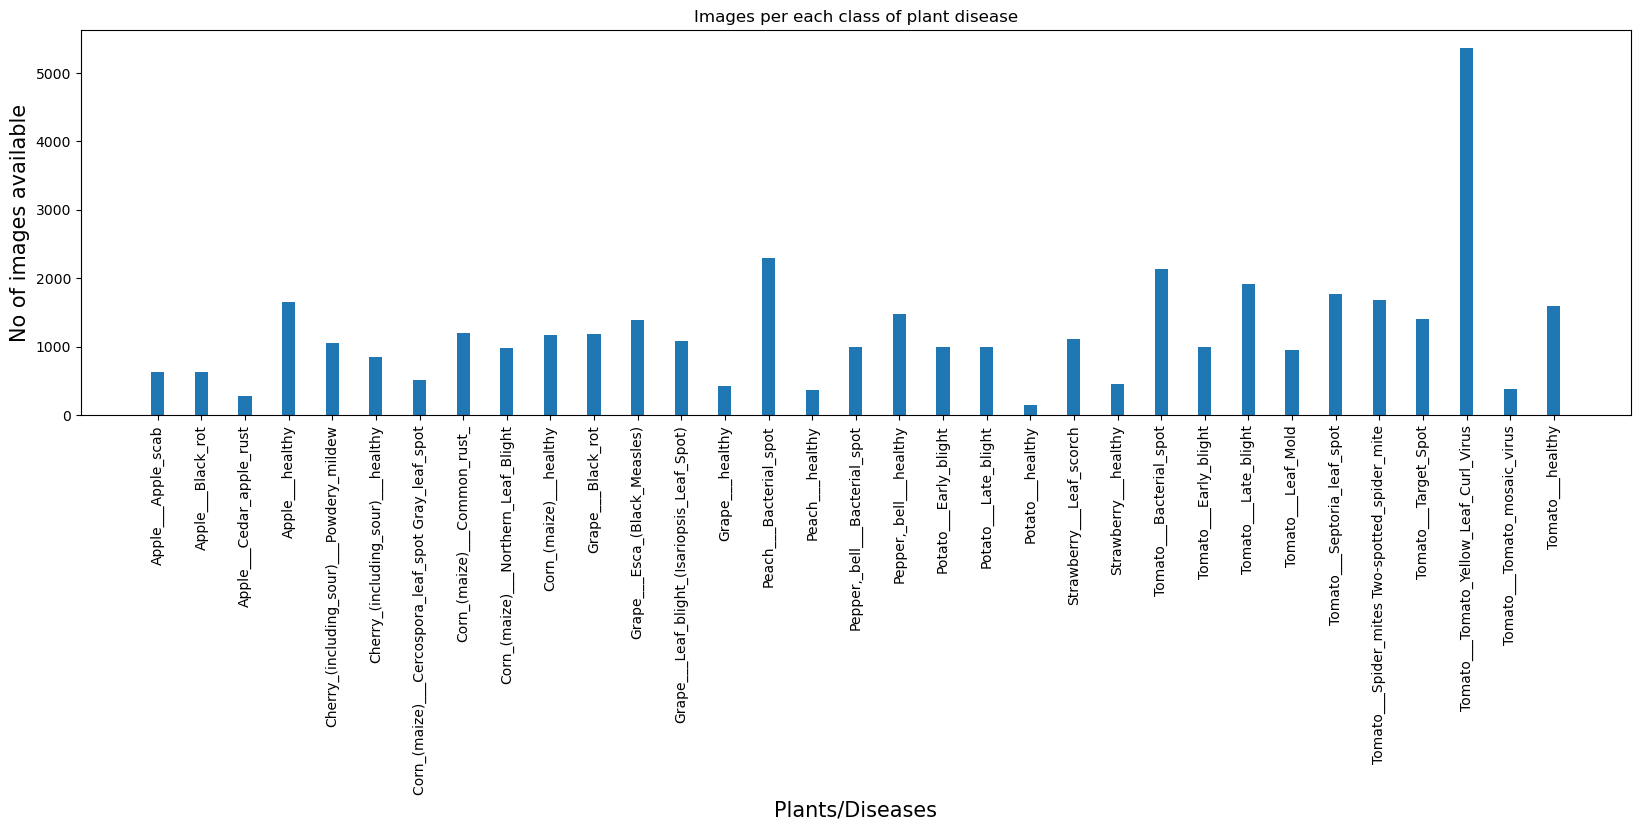

In [127]:
# plotting number of images available for each disease
index = [n for n in range(33)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=15)
plt.ylabel('No of images available', fontsize=15)
plt.xticks(index, class_names, fontsize=10, rotation=90)
plt.title('Images per each class of plant disease')

### DATA CLEANING AND PREPROCESSING

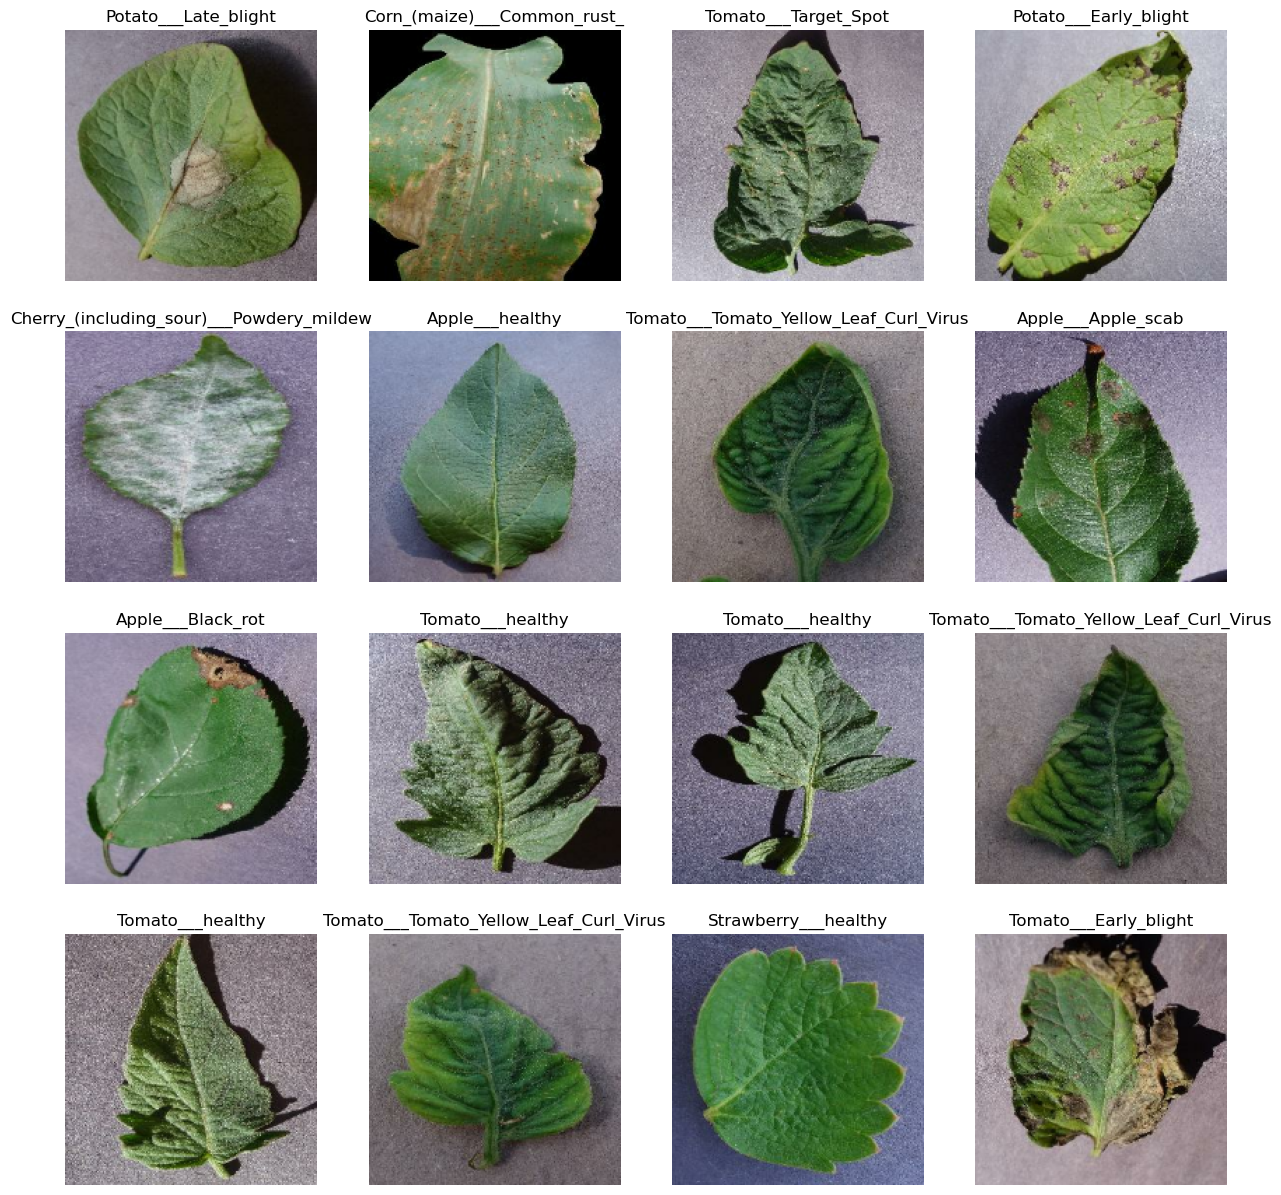

In [16]:
#Visualization of images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(9):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [128]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000, seed=5).prefetch(AUTOTUNE)
val_ds = val_ds.shuffle(1000, seed=5).prefetch(AUTOTUNE)
test_ds = test_ds.shuffle(1000, seed=5).prefetch(AUTOTUNE)

In [129]:
#To introduce variability in image positions
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

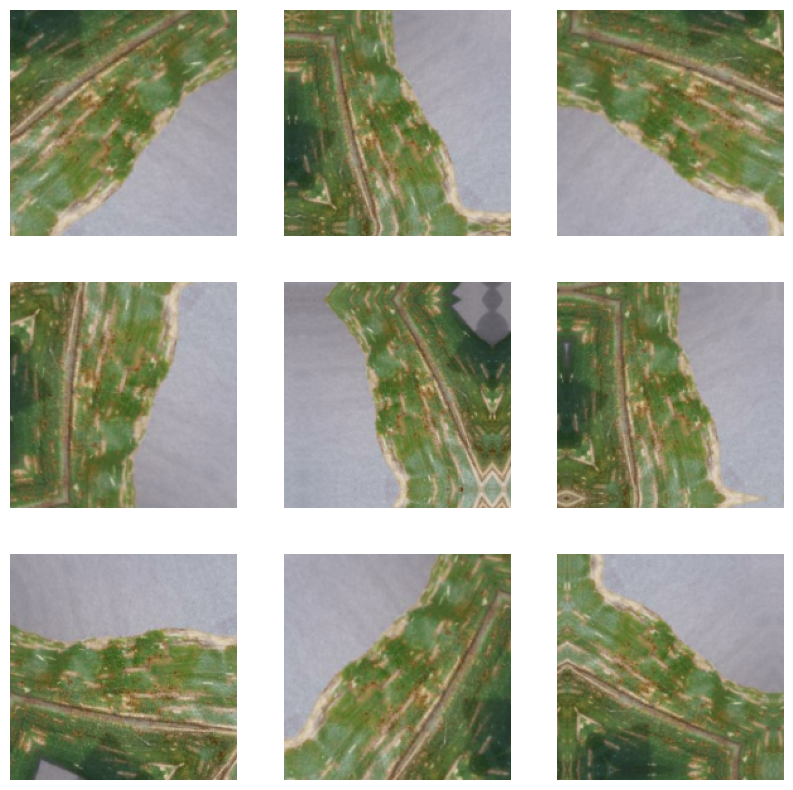

In [19]:
#Visualization of augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### MODEL BUILDING

In [29]:
num_classes = len(class_names)

model = Sequential([
    layers.Resizing(img_size, img_size), #For new input data
    layers.Rescaling(1./255), #Scaling data, RGB dimension is in 0-255 range
    data_augmentation,
    #cnn
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    #dense
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(num_classes, name="outputs", activation='softmax') #softmax normalizes the probability of the classes
])

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #Y output is in 
              metrics=['accuracy'])

In [24]:
model.build((32,img_size, img_size,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (32, 180, 180, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 90, 90, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 90, 90, 64)          18496     
                                                      

In [31]:
# Define a callback to modify the learning rate dynamically
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0001)

In [32]:
epochs=30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_callback]
)

Epoch 1/30


KeyboardInterrupt: 

In [33]:
epochs=50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_callback]
)

Epoch 1/50
1000/1000 [==============================] - 225s 80ms/step - loss: 2.0494 - accuracy: 0.4066 - val_loss: 1.0720 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 59s 48ms/step - loss: 0.8529 - accuracy: 0.7287 - val_loss: 0.5443 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - 56s 48ms/step - loss: 0.5502 - accuracy: 0.8201 - val_loss: 0.4411 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - 56s 48ms/step - loss: 0.4298 - accuracy: 0.8605 - val_loss: 0.3503 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 5/50
1000/1000 [==============================] - 56s 48ms/step - loss: 0.3512 - accuracy: 0.8850 - val_loss: 0.2487 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 6/50
1000/1000 [==============================] - 56s 48ms/step - loss: 0.3191 - accuracy: 0.8937 - val_loss: 0.2302 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 7/50
1000/1000 [=======================

5 conv2d, epoch 38 -> loss: 0.0988 - accuracy: 0.9673 - val_loss: 0.1085 - val_accuracy: 0.9685

epoch 38 -> loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.0524 - val_accuracy: 0.9872 - lr: 1.0000e-04 (callback)

epoch 48 -> loss: 0.1209 - accuracy: 0.9616 - val_loss: 0.0905 - val_accuracy: 0.9747
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    #dense
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    
    
epoch 30 -> loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0508 - val_accuracy: 0.9860 - lr: 1.0000e-04

In [130]:
model.evaluate(test_ds)

125/125 [==============================] - 3s 18ms/step - loss: 0.0287 - accuracy: 0.9905


[0.02872060053050518, 0.9904999732971191]

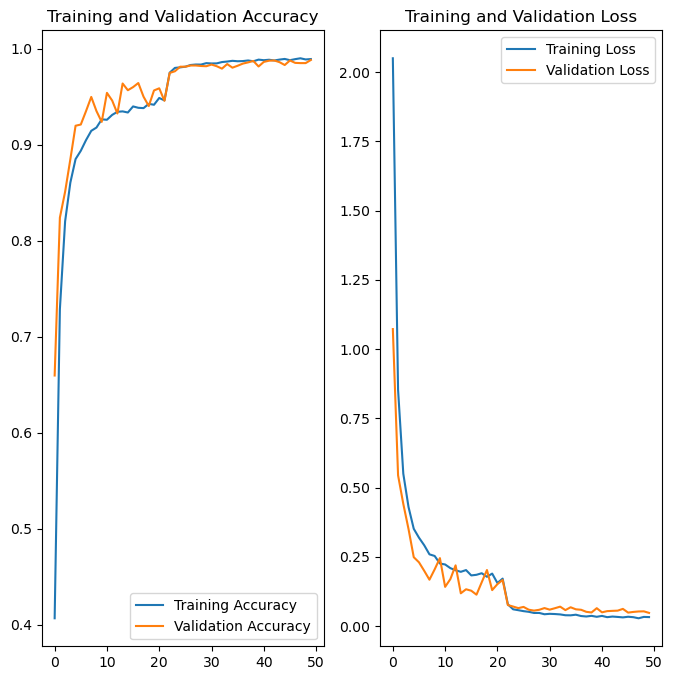

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [144]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [145]:
print(classification_report(correct_labels, predicted_labels, target_names = class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        55
                                 Apple___Black_rot       1.00      1.00      1.00        55
                          Apple___Cedar_apple_rust       0.96      1.00      0.98        27
                                   Apple___healthy       0.99      0.99      0.99       150
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99        97
                 Cherry_(including_sour)___healthy       1.00      0.98      0.99        87
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.91      0.91        35
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       110
               Corn_(maize)___Northern_Leaf_Blight       0.98      0.96      0.97        99
                            Corn_(maize)___healthy       1.00      1.00      1.

<Axes: >

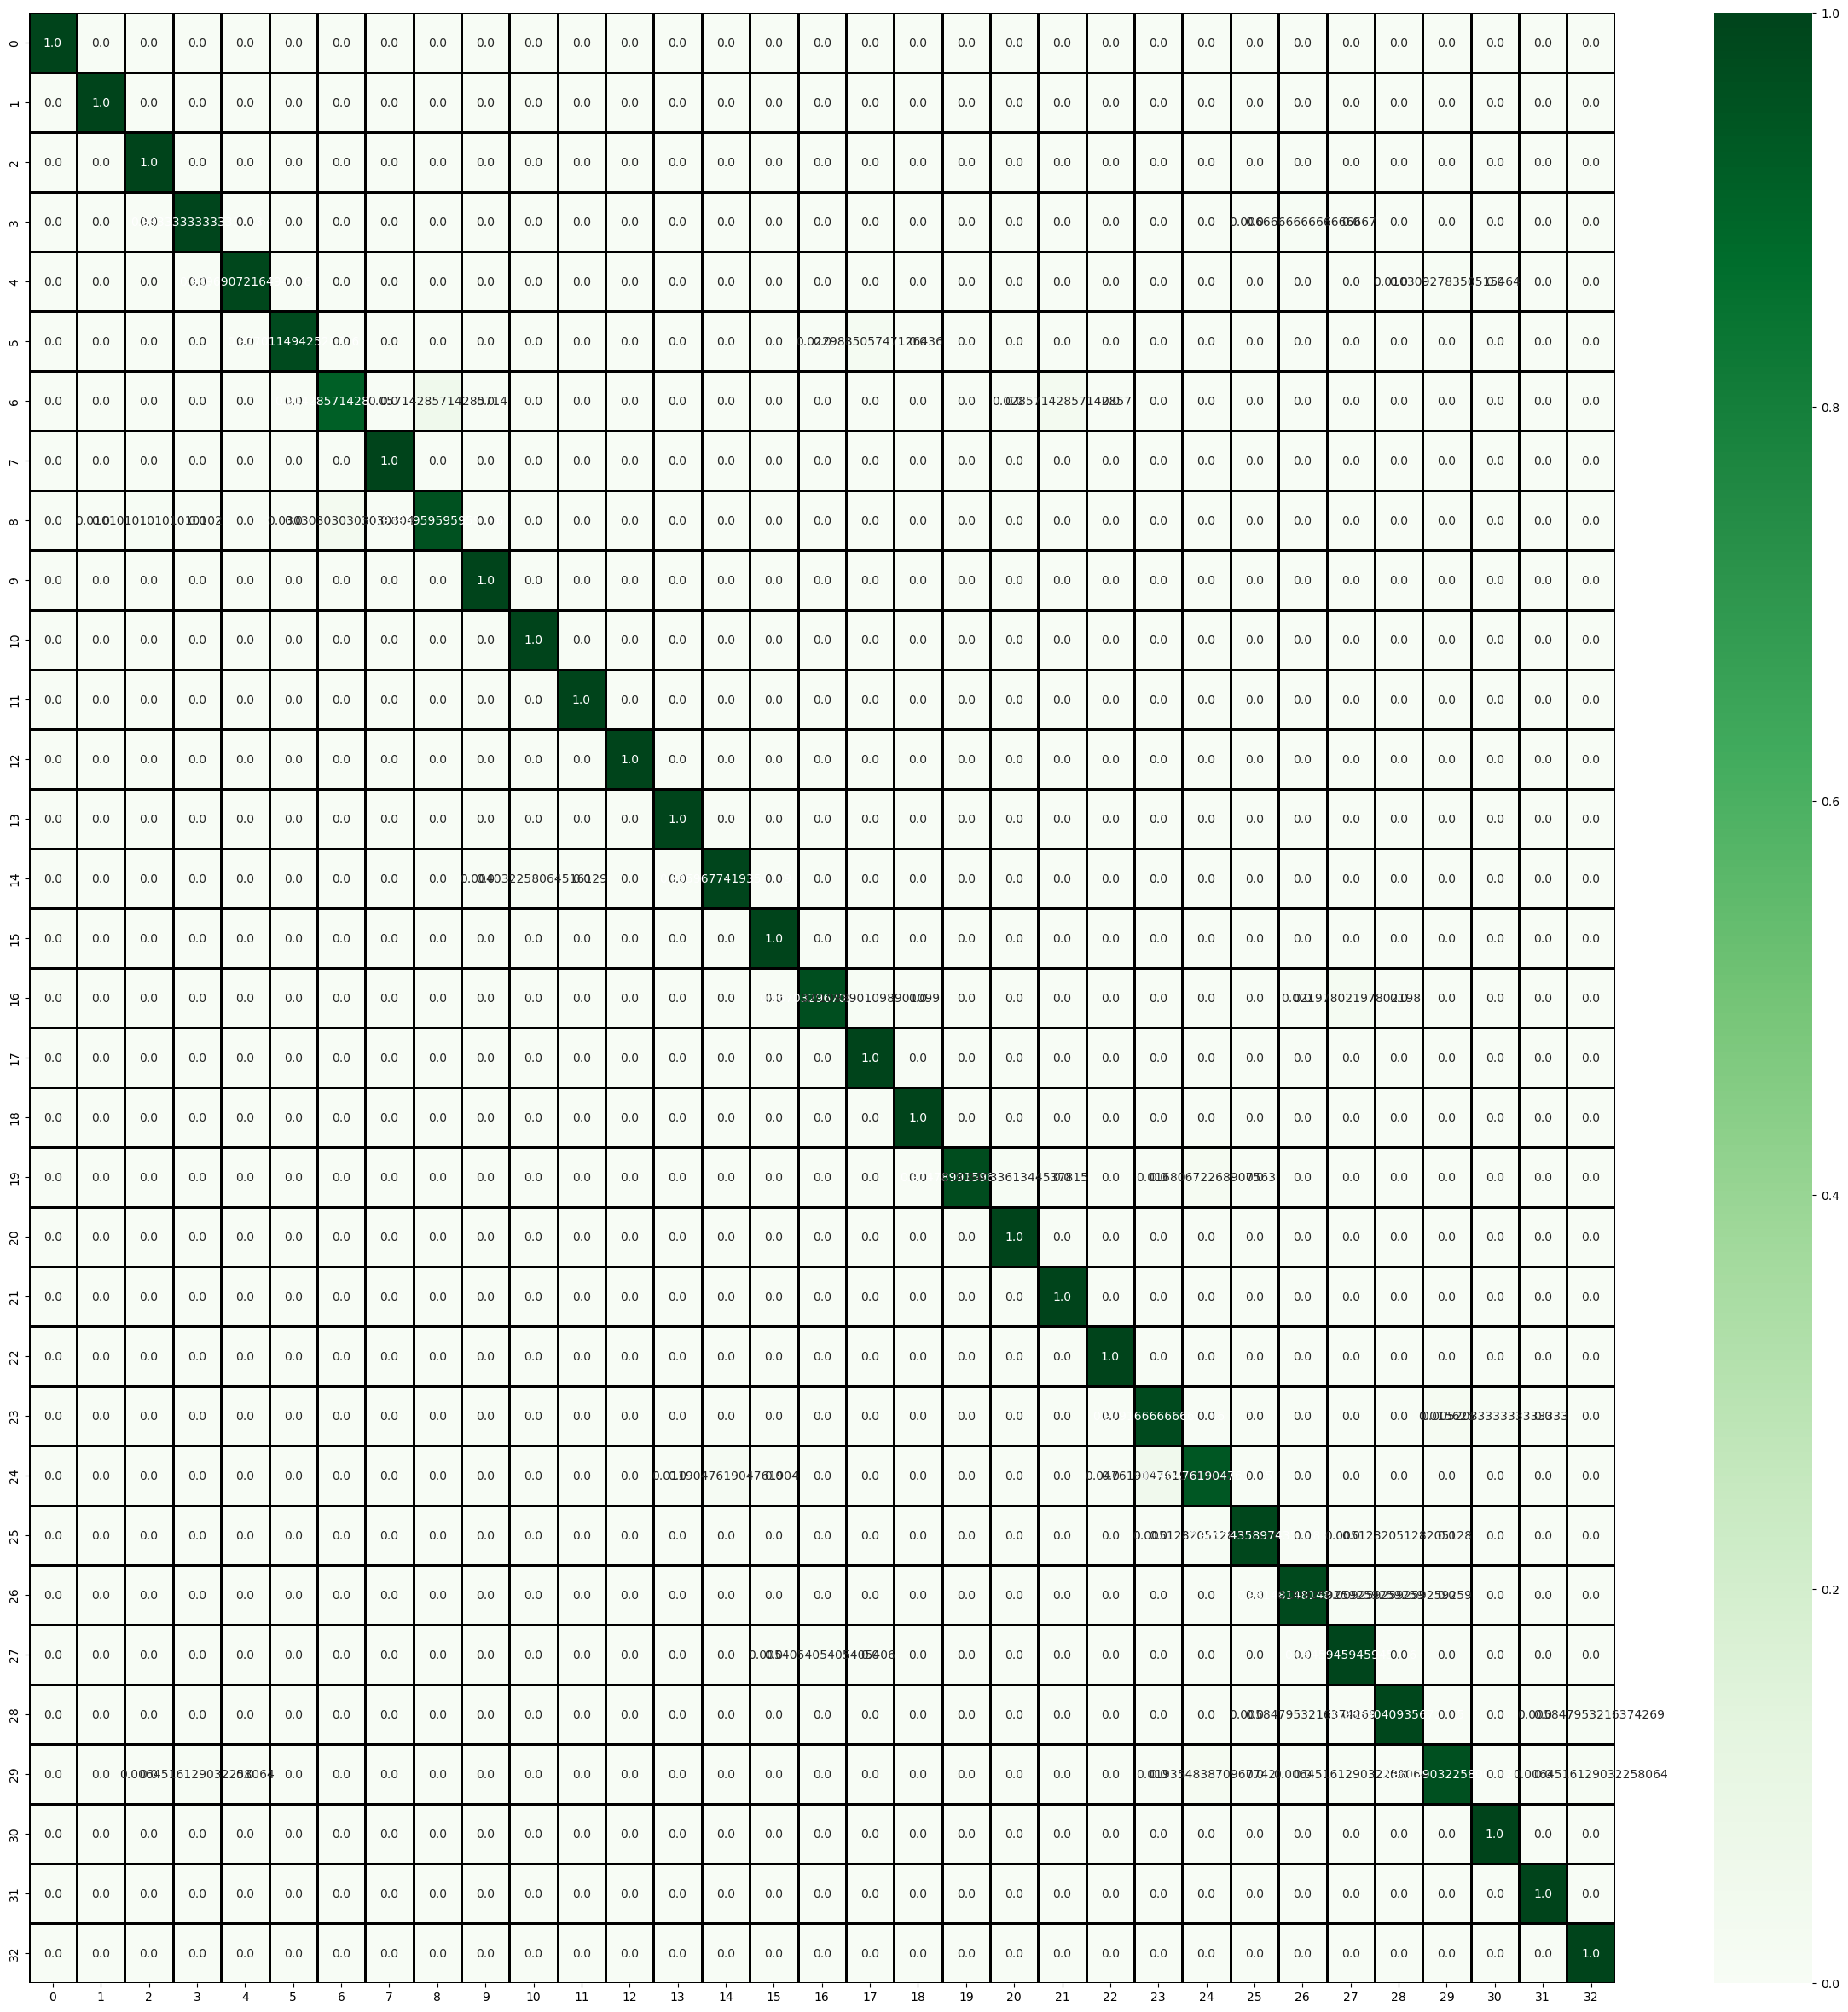

In [147]:
cm = confusion_matrix(correct_labels,predicted_labels, normalize='true')
cm = pd.DataFrame(cm , index = [i for i in range(len(class_names))] , columns = [i for i in range(len(class_names))])
plt.figure(figsize = (30,30))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')